# Upwelling Scaling

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import gsw
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import viz_tools, places
from itertools import repeat, groupby
from scipy.signal import butter, lfilter, argrelextrema
from warnings import simplefilter
from tqdm import tqdm_notebook as tqdm

%matplotlib inline
plt.rcParams['font.size'] = 12
simplefilter("ignore")

***

## Functions and definitions

Scaling diagram

In [3]:
def scaling_diagram():
    """Plot scaling diagram
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for attr in ['set_xlim', 'set_ylim']: getattr(ax, attr)([0, 1])
    ticks, labels = [(0, 0.1, 0.4, 1), (0, 0.7, 0.9, 1)], [(0, '$L_w$', '$R$', '$L$'), ('$H$', '$z_h$', '$z_u$', 0)]
    for attr, tick, label in zip(['xaxis', 'yaxis'], ticks, labels):
        getattr(ax, attr).set_ticks(tick)
        getattr(ax, attr).set_ticklabels(label)
    lines = [(0.0, 1.0, 0.7, 0.7, '-'), (0.0, 0.4, 0.9, 0.7, '--'), (0.1, 0.4, 1.0, 0.7, '--'), (0.4, 0.4, 1.0, 0.7, '--')]
    for line in lines: ax.plot(line[:2], line[2:4], 'k', linestyle=line[4])
    annotations = [(0.63, 0.89), (0.05, 0.77), (0.25, 0.90), (0.42, 0.80)]
    labels = ['$\\frac{\\tau}{\\rho_0f}$', '$\\frac{z_u}{z_h} < 1$', '$\\frac{z_u}{z_h} > 1$', '$\\frac{L_w}{R} > 1$']
    for annotation, label in zip(annotations, labels): ax.text(*annotation, label, size=18)
    ax.arrow(0.6, 0.95, 0.1, 0, head_width=0.02, color='k')

Make scaling figure

In [98]:
def make_scaling_figure():
    """
    """

    # Make figure layout
    fig, axs = plt.subplots(2, 3, figsize=(17, 10))
    xlabel = '$\\frac{\\tau T}{\\rho z_hfR}$'
    ylabels = ['$z_u/z_h$', '$L_w/R$']
    for i, row, ylabel in zip(range(2), axs, ylabels):
        for ax, hour in zip(row, hours):
            ax.set_xlim([0, 8])
            ax.set_ylim([0, 5])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if i == 0:
                ax.plot([0, 0.5], [0, 1], 'k--')
                ax.plot([0.5, 8], [1, 1], 'k--')
                ax.set_title(f'{hour} hours')
            else:
                ax.plot([1, 3.5], [0, 5], 'm--')
                ax.plot([0.5, 5.5], [0, 5], 'k--')

    return fig, axs

Make hindcast prefix

In [5]:
def make_prefix(date, paths, res='h'):
    """Make prefix
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    fn = '_'.join([f'SalishSea_1{res}', *repeat(date.strftime('%Y%m%d'), 2)])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

Rossby radius

In [31]:
def calc_deformation_radius(rho_surf, z_h, xy, angle=np.pi/2, tol=10):
    """Calculate the 2-layer baroclinic Rossby deformation radius
    """

    g_prime = const['g'] * (const['rho_0'] - rho_surf) / const['rho_0']
    R = np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H']) / const['f']
    H, H_old = const['H'], 0
    while abs(H - H_old) > tol:
        H_old = H
        H = int(bathy.Bathymetry[xy[1], slice(xy[0], xy[0] + int(R / np.sin(angle) / mask.e1t[xy[::-1]]))].mean())
        R = np.sqrt(g_prime * z_h * (H - z_h) / H) / const['f']

    return R

Calculate density $\rho$

In [45]:
def calc_rho(data, depth, loc, tmask, time=True):
    """Calculate the density, rho
    """
    
    if time: mskslc = slice(1, None)
    else: mskslc = slice(None, None)
    rho = gsw.rho(*[np.ma.masked_where(tmask[loc[mskslc]] == 0, data[k][loc]) for k in tracers], depth)
    
    return rho

Definitions

In [27]:
# Definitions
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc').isel(t=0)
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200}
depth2d = np.expand_dims(mask.gdept_1d, axis=1)
tracers = ['vosaline', 'votemper']
subdomain = [114, 398, 334, 898]
sections = [
    {'y': 450, 'x': (235, 315), 'a': np.arctan(10), 'c': 'r'},
    {'y': 500, 'x': (205, 295), 'a': np.arctan( 1), 'c': 'darkorange'},
    {'y': 540, 'x': (175, 255), 'a': np.arctan( 1), 'c': 'gold'},
    {'y': 590, 'x': (130, 205), 'a': np.arctan( 2), 'c': 'darkslategray'},
    {'y': 640, 'x': (120, 180), 'a': np.arctan(10), 'c': 'c'},
    {'y': 680, 'x': (130, 200), 'a': np.arctan( 5), 'c': 'cyan'},
]

***

## Scaling method

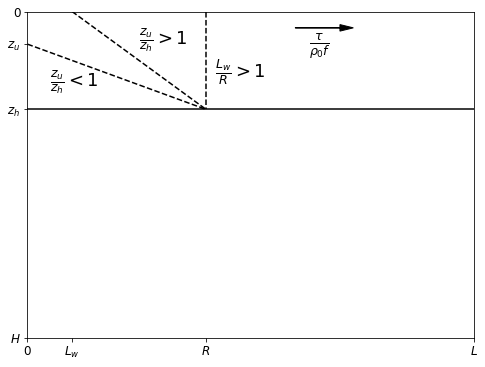

In [9]:
# Plot scaling diagram
scaling_diagram()

Conservation of mass (Ekman flux over time equals pycnocline displacement)

### Pycnocline shoaling

When $z_h/z_h < 1$

$$\frac{z_uR}{2} = \frac{\tau T}{\rho_0f}$$

where

$$R = \frac{1}{f}\left(\frac{g'z_h(H - z_h)}{H}\right)^{\frac{1}{2}}$$

Thus

$$\boxed{\hspace{0.5cm}\frac{z_u}{z_h} = \frac{2\tau T}{\rho_0z_hfR}\hspace{0.5cm}} \tag{1}$$

### Advection of the halocline front

When $z_u/z_h = 1$

$$\frac{z_h\left(R + L_w\right)}{2} = \frac{\tau T}{\rho_0f}$$

Considering again R

$$\boxed{\hspace{0.5cm}\frac{L_w}{R} = \frac{2\tau T}{\rho_0z_hfR} - 1\hspace{0.5cm}} \tag{2}$$

When $L_w/R > 1$

$$L_wz_h = \frac{\tau T}{\rho_0f}$$

$$\boxed{\hspace{0.5cm}\frac{L_w}{R} = \frac{\tau T}{\rho_0z_hfR}\hspace{0.5cm}} \tag{3}$$

***
## Domain sections
Plot domain sections

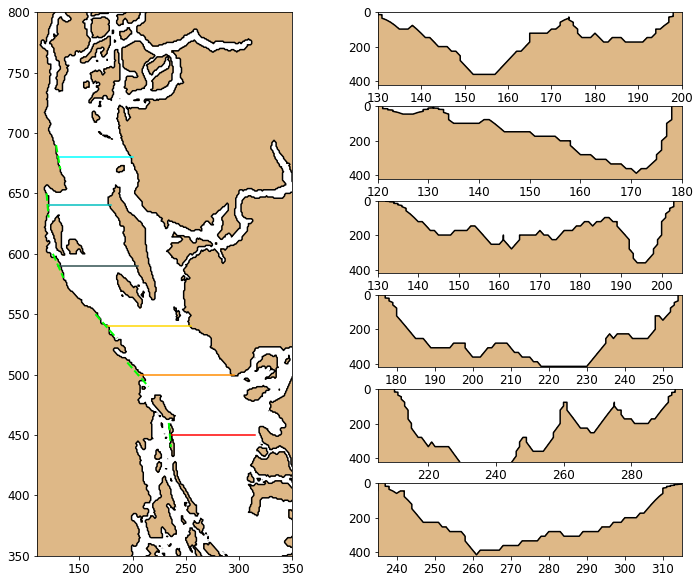

In [10]:
# Plot section locations
fig = plt.figure(figsize=(12, 10))
gs = plt.GridSpec(6, 2, hspace=0.3)
ax = fig.add_subplot(gs[:, 0])
ax.contourf(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
ax.contour(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([110, 350])
ax.set_ylim([350, 800])
viz_tools.set_aspect(ax)

# Plot section bathymetry
for row, sec in zip(range(6), sections):
    line = []
    for coord, slope in zip([sec['x'][0], sec['y']], [np.tan(sec['a']), -1]):
        line.append([coord + w / slope for w in [-10, 10]])
    ax_sec = fig.add_subplot(gs[5-row, 1])
    ax.plot(sec['x'], [sec['y'], sec['y']], '-', color=sec['c'])
    ax.plot(*line, '--', linewidth=2, color='lime')
    ax_sec.contourf(mask.x, mask.gdept_1d[0, :], mask.tmask[0, :, sec['y'], :], levels=[-0.01, 0.01], colors='Burlywood')
    ax_sec.contour(mask.x, mask.gdept_1d[0, :], mask.tmask[0, :, sec['y'], :], levels=[-0.01, 0.01], colors='k')
    ax_sec.set_xlim(sec['x'])
    ax_sec.set_ylim([420, 0])

***
## Idealized runs
Define paths and scaling parameters

In [28]:
# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
tmask = mask.tmask[:, slice(*subdomain[2:]), slice(*subdomain[:2])]

# Define scaling parameters
hours = [12, 24, 48]
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

R_def = [0, 0, 0, 0, 0, 0]

Idealized scaling calculations

In [29]:
def calc_scaling_ideal():
    """
    """
    
    # Make figure layout
    fig, axs = make_scaling_figure()
    
    # Loop though z_h and rho_surf
    for z_h in tqdm(param['z_h']):
        for rho_s in param['rho_surf']:
            
            # Calculate deformation radius
            for i, sec in zip(range(6), sections):
                R_def[i] = calc_deformation_radius(rho_s, z_h, (sec['x'][0], sec['y']), angle=sec['a'])
                
            # Loop through wind speed
            for U, tau in zip(param['u_wind'], param['tau']):
                
                # Open results record
                runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
                with xr.open_dataset(os.path.join(path, runID, fn)) as data:
                    
                    # Loop through sections
                    for sec, R in zip(sections, R_def):
                        scale = np.cos(np.arctan(2) - sec['a']) * tau * 3600 / (const['rho_0'] * z_h * const['f'] * R)
                        xy = (sec['y'] - subdomain[2], slice(*[x - subdomain[0] for x in sec['x']]))
                        rho_t0 = calc_rho(data, depth2d, (0, slice(None)) + xy, tmask)
                        rho_halo = np.median(rho_t0[abs(depth2d[:, 0] - z_h).argmin(), :])
                        
                        # Loop through hours
                        for col, hour in zip(axs.T, hours):
                            scale_T = (hour - 3) * scale
                            rho = calc_rho(data, 0, (hour, 0) + xy, tmask)
                            z_u = depth2d[int(np.median(abs(rho_t0 - rho.max()).argmin(axis=0))), 0] / z_h
                            L_w = np.sin(sec['a']) * (rho >= rho_halo).sum() * 440 / R
                            col[0].plot(scale_T, z_u, 'o', color=sec['c'], markeredgecolor='k')
                            col[1].plot(scale_T, L_w, 'o', color=sec['c'], markeredgecolor='k')

### Plot idealized scaling

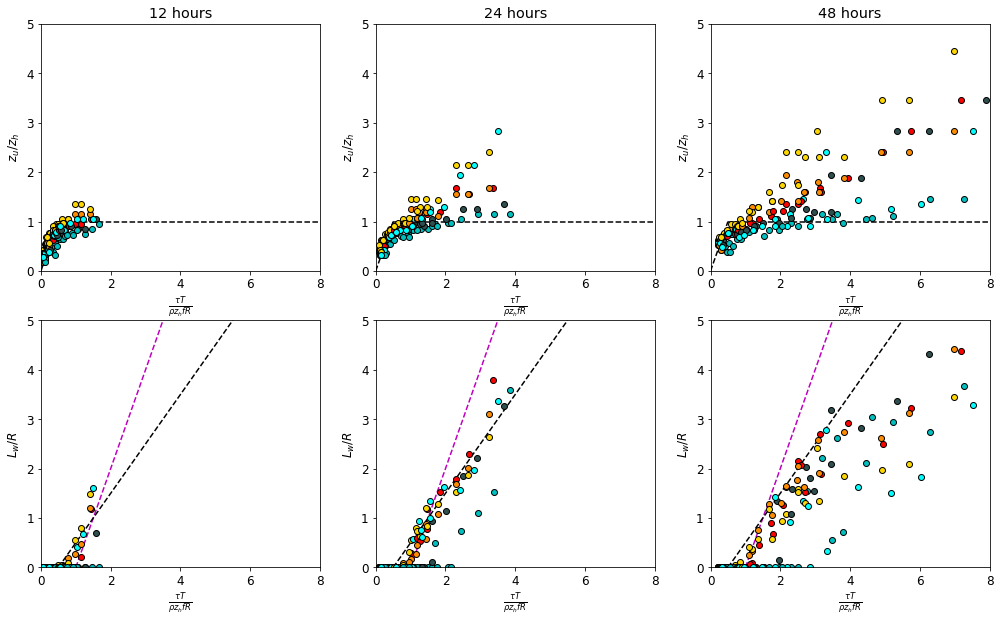

In [36]:
calc_scaling_ideal()

***

## Hindcast record

Define netCDF objects and paths

In [41]:
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
tmask = mask.tmask
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'date_cutoff': '2016 Nov 21',
}
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']

Define upwelling event start dates

In [42]:
# Upwelling event date windows
events = [
    ['2015 Mar 11 01:00', 6],
    ['2015 Mar 18 16:00', 4],
    ['2015 Mar 24 19:00', 3],
    ['2015 Mar 28 18:00', 7],
    ['2015 Apr 25 22:00', 5],
    ['2016 Apr 11 12:00', 5],
    ['2017 Apr 03 20:00', 6],
    ['2017 May 30 15:00', 3],
    ['2017 Sep 09 00:00', 5],
    ['2017 Sep 16 20:00', 4],
    ['2017 Oct 20 23:00', 5],
    ['2018 Mar 22 04:00', 5],
    ['2018 Apr 03 07:00', 10],
    ['2018 Apr 12 23:00', 2],
    ['2018 Sep 07 11:00', 3],
    ['2018 Sep 14 18:00', 5],
    ['2018 Oct 23 06:00', 2],
]
events = [{'date': parse(event[0]), 'z_h': event[1]} for event in events]

Extract results

ValueError: cannot convert float NaN to integer

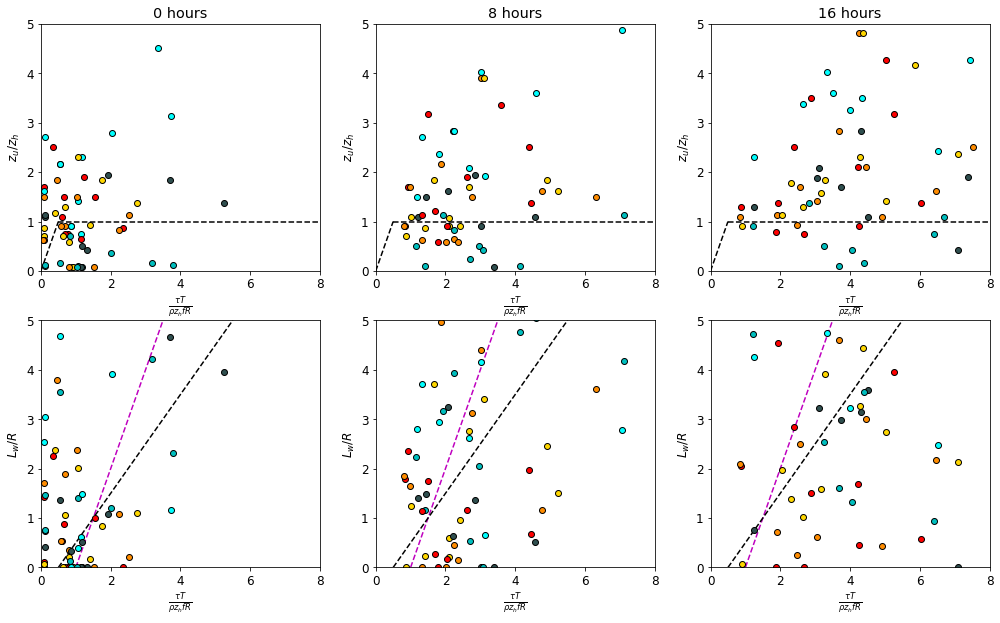

In [103]:
# Make figure layout
fig, axs = make_scaling_figure()

hours = [0, 8, 16, 24]

for event in tqdm(events):
    for sec in sections:
        xy = (sec['y'], slice(*sec['x']))
        for i, hour in enumerate(hours):
            date = event['date'] + timedelta(hours=hour)
            with xr.open_dataset(make_prefix(date, paths) + '_grid_T.nc').sel(time_counter=date, method='nearest') as data:
                if hour == 0:
                    rho_t0 = calc_rho(data, depth2d, (slice(None),) + xy, tmask, time=False)
                    rho_halo = np.median(rho_t0[abs(depth2d[:, 0] - event['z_h']).argmin(), :].compressed())
                    rho_s = rho_t0[:event['z_h'], :].mean()
                    R = calc_deformation_radius(rho_s, event['z_h'], (sec['x'][0], sec['y']), angle=sec['a'])
                else:
                    v_wind = HRDPS.v_wind.sel(time=slice(event['date'], date))[:, j, i].values
                    tau = sum(1.225e-3 * v_wind**2) * 3600
                    scale_T = np.cos(np.arctan(2) - sec['a']) * tau / (const['rho_0'] * event['z_h'] * const['f'] * R)
                    rho = calc_rho(data, 0, (0,) + xy, tmask, time=False)
                    rho_max = rho[:int(R / 440)].max()
                    z_u = depth2d[int(np.median(abs(rho_t0 - rho_max).argmin(axis=0))), 0] / event['z_h']
                    L_w = np.sin(sec['a']) * (rho >= rho_halo).sum() * 440 / R
                    axs[0, i-1].plot(scale_T, z_u, 'o', color=sec['c'], markeredgecolor='k')
                    axs[1, i-1].plot(scale_T, L_w, 'o', color=sec['c'], markeredgecolor='k')